## Inference of Catboost model to predict monthly spatial flux of NEE and related UQ
-----


In [7]:
!pip -q install earthengine-api


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [12]:
!pip -q install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip -q install "numpy<2"
!pip -q install scikit-image
!pip -q install rasterio
!pip -q install xarray[complete]
!pip3 -q install rioxarray
!pip -q install catboost
!pip -q install geemap


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
!pip3 -q install aiohttp


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
np.__version__

'1.26.4'

In [1]:
import ee
import os
import pandas as pd
import  numpy as np
import geemap
import rasterio as rio
import rioxarray
import pickle
import requests
import geopandas as gpd
from datetime import datetime
import datetime as dt
from skimage import transform
from scipy.ndimage import zoom
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from rasterio.plot import show

import fsspec
import xarray as xr
from shapely.geometry import box

# import catboost as cb
from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings('ignore')

In [3]:
import ee
ee.Authenticate()

Enter verification code:  4/1AQlEd8z1WzDsgA4c731MrbZy_rVcRo_embY1dTIlj4QDv2Sy-bqCGuZ0Xps



Successfully saved authorization token.


Init ee - https://developers.google.com/earth-engine/guides/auth

In [4]:
gee_cloud_project_name = 'level-works-294421'
ee.Initialize(project=gee_cloud_project_name)

In [5]:
class EEdownloader:
    def __init__(self, directory: str, region_name: str = "Tver Oblast"):
        self.region_name = region_name
        self.region = self.get_region_bounds(region_name)
        self.directory = directory

    def get_region_bounds(self, region_name: str):
        ISO = "RUS"
        ADM = "ADM1"
        release_type = "gbOpen"
        url = (
            f"https://www.geoboundaries.org/api/current/{release_type}" f"/{ISO}/{ADM}"
        )
        r = requests.get(url)
        gdf = gpd.read_file(r.json()["simplifiedGeometryGeoJSON"])

        mask = gdf["shapeName"] == region_name
        if len(gdf.loc[mask]) == 0:
            raise KeyError(f"No such region - {region_name}")
        gdf = gdf.loc[mask]
        return geemap.geopandas_to_ee(gdf)

    def download_gpp(self, year, month, file_name):
        """
        Download the mean GPP data for a specific year and month for a given region.

        Parameters:
        year (int): The year of interest.
        month (int): The month of interest.
        local_file_path (str): The local file path to save the data.
        """
        # Define the start and end dates for the specified month and year
        start_date = datetime(year, month, 1).strftime('%Y-%m-%d')
        end_date = (datetime(year, month + 1, 1) if month < 12 else datetime(year + 1, 1, 1)).strftime('%Y-%m-%d')

        # Load the MODIS GPP dataset
        dataset = ee.ImageCollection('MODIS/006/MOD17A2H')

        # Filter the dataset for the desired time range
        gpp = dataset.filterDate(start_date, end_date).select('Gpp')

        # Calculate the mean GPP over the time period
        mean_gpp = gpp.mean()

        # Clip the data to the region of interest
        clipped_gpp = mean_gpp.clip(self.region)

        # Download the image
        geemap.ee_export_image(clipped_gpp, filename=os.path.join(self.directory, file_name), scale=500, region=self.region.geometry(), file_per_band=False)

    def download_igbp(self, file_name):
        """
        Download the land cover data for a specific year for a given region.

        Parameters:
        year (int): The year of interest.
        local_file_path (str): The local file path to save the data.
        """
        # Define the start and end dates for the specified year
        start_date = datetime(2022, 1, 1).strftime('%Y-%m-%d')
        end_date = datetime(2022 + 1, 1, 1).strftime('%Y-%m-%d')

        # Load the MODIS Land Cover dataset
        dataset = ee.ImageCollection('MODIS/061/MCD12C1')

        # Filter the dataset for the desired year
        land_cover = dataset.filterDate(start_date, end_date).first().select('Majority_Land_Cover_Type_1')

        # Clip the data to the region of interest
        clipped_land_cover = land_cover.clip(self.region)

        # Download the image
        geemap.ee_export_image(clipped_land_cover, filename=os.path.join(self.directory, file_name), scale=5000, region=self.region.geometry(), file_per_band=False)

In [100]:
class Inference:
    def __init__(self):
        self.solar_variables = ["ALLSKY_SRF_ALB", 'PW','CLRSKY_SRF_ALB', 'ZENITH_LUMINANCE']

        self.weather_variables = ['Z0M', 'RHOA', 'WS50M_MIN', 'TS_RANGE']

    def get_region_bounds(self, region_name: str = "Tver Oblast"):
        ISO = "RUS"
        ADM = "ADM1"
        release_type = "gbOpen"
        url = (
            f"https://www.geoboundaries.org/api/current/{release_type}" f"/{ISO}/{ADM}"
        )
        r = requests.get(url)
        gdf = gpd.read_file(r.json()["simplifiedGeometryGeoJSON"])

        mask = gdf["shapeName"] == region_name
        if len(gdf.loc[mask]) == 0:
            raise KeyError(f"No such region - {region_name}")
        gdf = gdf.loc[mask]
        return gdf


    def clip_netCDF_by_region(
        self, ds: xr.Dataset, gdf: gpd.GeoDataFrame, use_bbox: bool = False
    ):
        """clip_netCDF_by_region _summary_

        Crop xarray by some polygon, for example, country

        Args:
        ds (xr.core.dataset.Dataset): _description_
        gdf (gpd.GeoDataFrame): Defaults to gpd.GeoDataFrame.

        Returns: xr
        """
        gdf = gdf.to_crs("EPSG:4326")  # type: ignore
        ds.rio.write_crs("epsg:4326", inplace=True)
        if use_bbox:
            clipped = ds.rio.clip([box(*gdf.total_bounds)], gdf.crs)
            return clipped
        clipped = ds.rio.clip(gdf.geometry.values, gdf.crs)
        return clipped

    def get_weather_datasets(
        self, gdf: gpd.GeoDataFrame, target_year: str, target_month: str
    ):
        product = "power_901_daily_meteorology_utc.zarr"

        solar_product = "power_901_daily_radiation_utc.zarr"

        filepath = f"https://power-analysis-ready-datastore.s3.amazonaws.com/{product}"

        filepath_mapped = fsspec.get_mapper(filepath)
        ds = xr.open_zarr(store=filepath_mapped, consolidated=True)

        filepath = (
            f"https://power-analysis-ready-datastore.s3.amazonaws.com/{solar_product}"
        )
        filepath_mapped = fsspec.get_mapper(filepath)
        ds_solar = xr.open_zarr(store=filepath_mapped, consolidated=True)

        solar_variables = self.solar_variables
        weather_variables = self.weather_variables

        ds_solar = ds_solar[solar_variables]
        ds = ds[weather_variables]

        ds_solar = self.clip_netCDF_by_region(ds=ds_solar, gdf=gdf, use_bbox=True)
        ds = self.clip_netCDF_by_region(ds=ds, gdf=gdf, use_bbox=True)
        time_range = self.get_month_start_end(year=target_year, month=target_month)
        ds = ds.sel(time=time_range)
        ds_solar = ds_solar.sel(time=time_range)

        ds_solar.load()
        ds.load()
        return ds, ds_solar

    def get_month_start_end(self, year, month):
        year = int(year)
        month = int(month)
        start_date = f"{year:04d}-{month:02d}-01"
        _, end_day = calendar.monthrange(year, month)
        end_date = f"{year:04d}-{month:02d}-{end_day:02d}"
        return slice(start_date, end_date)
    
    
    from skimage import transform
    from scipy.ndimage import zoom

    def interpolate_integer_tiff(self, data: np.ndarray, original_shape:tuple, target_shape:tuple):
        zoom_factors = (1, target_shape[0] / original_shape[0], target_shape[1] / original_shape[1])
        interpolated_data = zoom(data, zoom_factors, order=0).astype(data.dtype)
        return interpolated_data

    def prepare_dataset(
        self, gpp_fname: pd.DataFrame, igbp_fname: pd.DataFrame, ds: xr.Dataset, ds_solar: xr.Dataset
        ):
        dataset = {}
        with rio.open(gpp_fname, "r+") as src:
            pixels = src.read()
            future_shape = pixels.shape
        dataset['GPP'] = pixels

        with rio.open(igbp_fname, "r+") as src:
            pixels = src.read()
            original_shape = src.shape
            pixels_resized = self.interpolate_integer_tiff(data=pixels, original_shape=original_shape, target_shape=future_shape[1:])
        dataset['IGBP'] = pixels_resized

        for weather_var in self.weather_variables:
            if weather_var == "PRECTOTCORR":
                x = ds[weather_var].sum(dim="time").values
            x = ds[weather_var].mean(dim="time").values
            x_resized = transform.resize(x, output_shape=future_shape[1:], order=3)
            dataset[weather_var] = x_resized

        for sun_var in self.solar_variables:
            x = ds_solar[sun_var].mean(dim="time").values
            x_resized = transform.resize(x, output_shape=future_shape[1:], order=3)
            dataset[sun_var] = x_resized
        self.data_input = dataset.copy()
        for key, item in dataset.items():
            dataset[key] = item.flatten()
        df = pd.DataFrame(dataset)
        return df

    def data_preprocessing(self, df):
        desired_order = ['GPP', 'IGBP', 'Z0M', 'RHOA', 'PW', 'ALLSKY_SRF_ALB', 'TS_RANGE',
                 'CLRSKY_SRF_ALB', 'WS50M_MIN', 'ZENITH_LUMINANCE']
        df = df[desired_order]
        X = df

        categorical_features = ['IGBP']
        file_name = './spatial_scaler.sav'
        with open(file_name,'rb') as file:
            scaler = pickle.load(file)

        X_num = X.drop(columns=categorical_features)

        X_num_scaled = scaler.transform(X_num)

        X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=X_num.columns, index=X_num.index)
        X_scaled = pd.concat([X_num_scaled_df, X[categorical_features]], axis=1)

        pool = Pool(data=X_scaled, cat_features=categorical_features)

        return pool

    def nee_model(self, data_pool):
        model_filename = 'Catboost_NEE_model.cbm'
        catboost_model = CatBoostRegressor(iterations=1000,
                                           learning_rate=0.1, 
                                           depth=6, 
                                           verbose=100)
        catboost_model.load_model(model_filename)

        predictions = catboost_model.predict(data_pool)

        return predictions



    
    def nee_uncertancy(self, data_pool):

        model_filename_lower = 'catboost_model_quantile_0.05.cbm'
        model_filename_upper = 'catboost_model_quantile_0.95.cbm'
        model_filename = 'Catboost_NEE_model.cbm'
        mean_model = CatBoostRegressor(iterations=1000,
                                           learning_rate=0.1, 
                                           depth=6, 
                                           verbose=100)


        
        lower_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
        upper_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
        mean_model.load_model(model_filename)
        lower_model.load_model(model_filename_lower)
        upper_model.load_model(model_filename_upper)

        preds_mean = mean_model.predict(data_pool)
        preds_lower = lower_model.predict(data_pool)
        preds_upper = upper_model.predict(data_pool)
        
        pir = (preds_upper - preds_lower) / preds_mean
        range_between = preds_upper - preds_lower
        self.preds = {'Q95': preds_upper, 'Q05': preds_lower, 'mean': preds_mean}
        return range_between

    def modelling(self, df: pd.DataFrame) -> np.ndarray:
        mask = (
            # df["GPP"] < 32761
            df["GPP"] > 0
        )  # отсюда - https://lpdaac.usgs.gov/products/mod17a2hgfv061/

        df["predicted"] = np.nan
        df["unsertancy"] = np.nan
        df_to_model = df.loc[mask]
        data_pool = self.data_preprocessing(df_to_model)


        prediction = self.nee_model(data_pool)
        unsertancy = self.nee_uncertancy(data_pool)
        df.loc[mask, "predicted"] = prediction

        df.loc[mask, "predicted"] = prediction
        df.loc[mask, "unsertancy"] = unsertancy
        x = df["predicted"].values
        uq = df["unsertancy"].values
        return x, uq

    # fname = modis_df["gpp"].values[0]
    def save_tiff(self, fname: str, x: np.ndarray, out_name: str):
        with rio.open(fname, "r+") as src:
            meta = src.meta
            meta["count"] = 1
            meta["nodata"] = np.nan
            meta["dtype"] = "float32"
            x = x.reshape((meta["height"], meta["width"]))
            with rio.open(out_name, "w", **meta) as dst:
                dst.write_band(1, x)



In [124]:
inference = Inference()
data_filepath = '/home/'
region = "Tver Oblast"
year = 2022
month = 6

gdf = inference.get_region_bounds(region_name="Tver Oblast")

# for month in range(1,13):
gpp_file = f'Tver_Oblast_GPP_{month}.tif'
igbp_file = f"Tver_Oblast_IGBP_{month}.tif"
ee_dowloader = EEdownloader(data_filepath, region)
ee_dowloader.download_gpp(year, month, gpp_file)
ee_dowloader.download_igbp(igbp_file)
ds, ds_solar = inference.get_weather_datasets(
  gdf=gdf, 
  target_year=int(year), 
  target_month=str(month))
df = inference.prepare_dataset(gpp_file_path, 
                             igbp_file_path,  
                             ds, 
                             ds_solar)

x,unsertancy = inference.modelling(df)

inference.save_tiff(fname=gpp_file_path, 
                  x=x, 
                  out_name=os.path.join(result_path, f"NEE_{month}_{year}.tif"))
inference.save_tiff(fname=gpp_file_path, 
                  x=unsertancy, 
                  out_name=os.path.join(result_path, f"Unsertancy_Range_Between_{month}_{year}.tif"))
# break

Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_GPP_6.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_IGBP_6.tif


In [109]:
os.makedirs('plots')

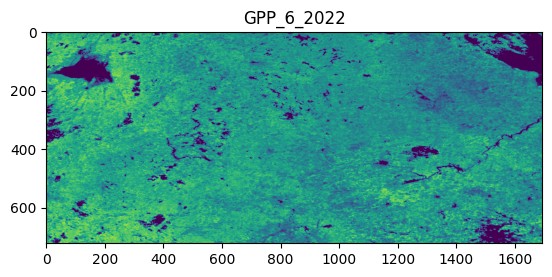

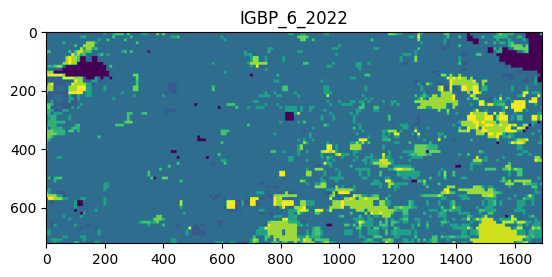

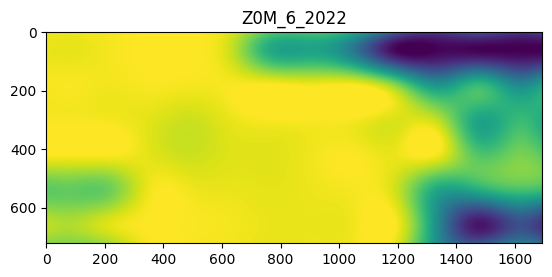

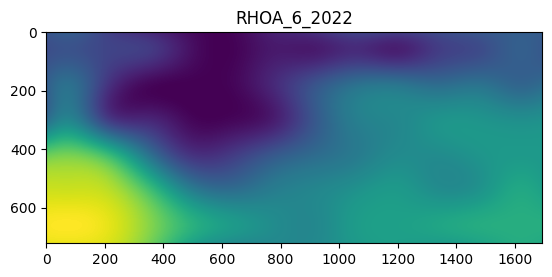

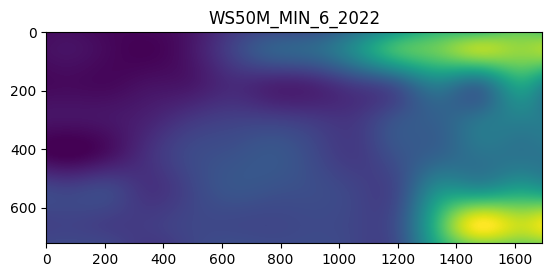

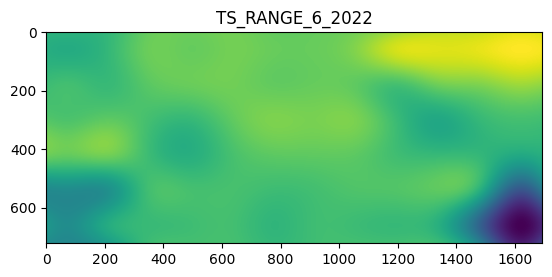

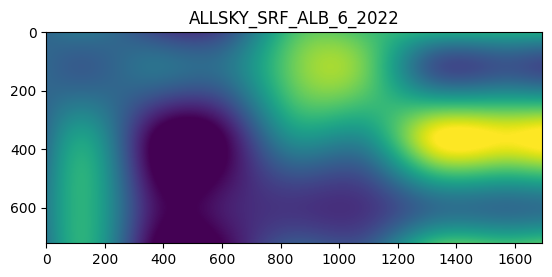

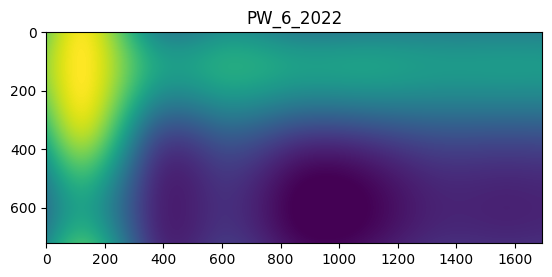

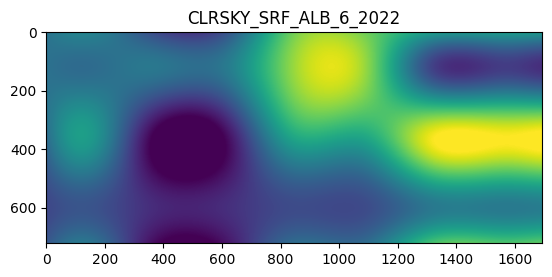

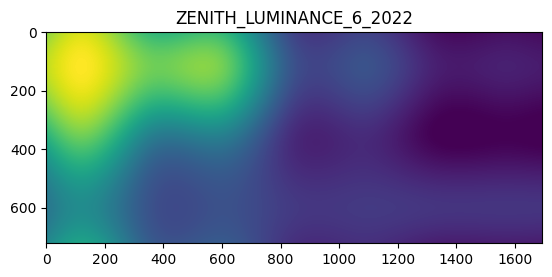

In [125]:
data_input = inference.data_input 
for key in data_input:
    try: 
        plt.imshow(data_input[key])
    except:
        plt.imshow(data_input[key][0])
    plt.title(f'{key}_{month}_{year}')
    plt.savefig(f'./plots/{key}_{month}_{year}.png')
    plt.show()
    # print(data_input[key].shape)

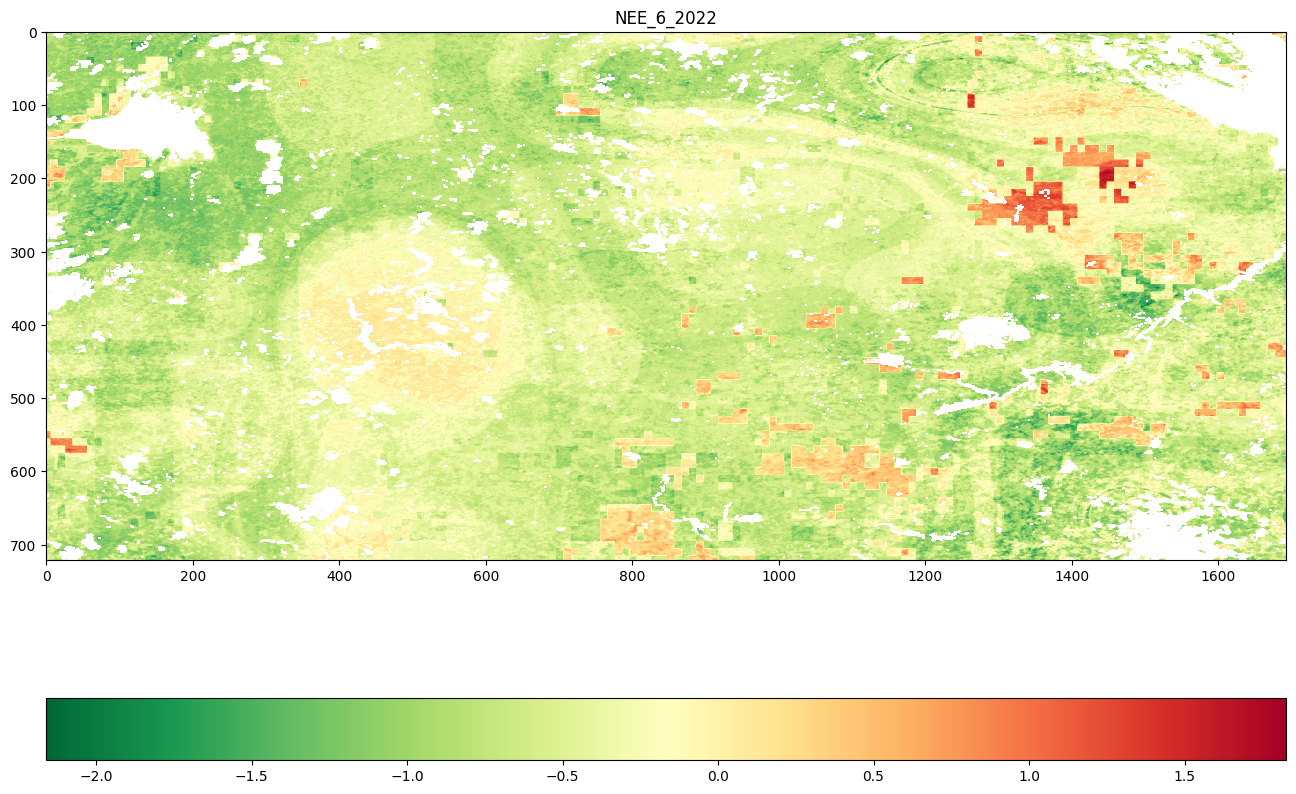

In [126]:
# month = 6
with rio.open(f'/home/NEE_{month}_{year}.tif', 'r') as src:
    data = src.read()

    plt.figure(figsize=(16, 12))
    img = plt.imshow(data[0], cmap='RdYlGn_r')
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.title(f'NEE_{month}_{year}')
    plt.savefig(f'./plots/result_month_{month}_{year}.png')
    plt.show()

In [78]:
inference = Inference()
data_filepath = '/home/'
region = "Tver Oblast"
year = 2022
month = 5

gdf = inference.get_region_bounds(region_name="Tver Oblast")

for month in range(1,13):
  gpp_file = f'Tver_Oblast_GPP_{month}.tif'
  igbp_file = f"Tver_Oblast_IGBP_{month}.tif"
  ee_dowloader = EEdownloader(data_filepath, region)
  ee_dowloader.download_gpp(year, month, gpp_file)
  ee_dowloader.download_igbp(igbp_file)
  ds, ds_solar = inference.get_weather_datasets(
      gdf=gdf, 
      target_year=int(year), 
      target_month=str(month))
  df = inference.prepare_dataset(gpp_file_path, 
                                 igbp_file_path,  
                                 ds, 
                                 ds_solar)

  x,unsertancy = inference.modelling(df)
  
  inference.save_tiff(fname=gpp_file_path, 
                      x=x, 
                      out_name=os.path.join(result_path, f"NEE_{month}_{year}.tif"))
  inference.save_tiff(fname=gpp_file_path, 
                      x=unsertancy, 
                      out_name=os.path.join(result_path, f"Unsertancy_Range_Between_{month}_{year}.tif"))
  # break

Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_GPP_1.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_IGBP_1.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_GPP_2.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_IGBP_2.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_GPP_3.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_IGBP_3.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_GPP_4.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_IGBP_4.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_GPP_5.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_IGBP_5.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_GPP_6.tif
Generating URL ...
Please wait ...
Data downloaded to /home/Tver_Oblast_IGBP_6.tif
Generating

In [29]:
inference = Inference()
gpp_file_path = '/home/Tver_Oblast_GPP.tif'
igbp_file_path = '/home/Tver_Oblast_IGBP.tif'
result_path = '/home'

gdf = inference.get_region_bounds(region_name="Tver Oblast")
ds, ds_solar = inference.get_weather_datasets(
    gdf=gdf, target_year=int(year), target_month=str(month)
)
df = inference.prepare_dataset(gpp_file_path, igbp_file_path,  ds, ds_solar)

x, uq = inference.modelling(df)
inference.save_tiff(fname=gpp_file_path, x=x, out_name=os.path.join(result_path, f"NEE_{month}_{year}.tif"))
  
inference.save_tiff(fname=gpp_file_path, x=x, out_name=os.path.join(result_path, f"NEE_{month}_{year}.tif"))
inference.save_tiff(fname=gpp_file_path, x=uq, out_name=os.path.join(result_path, f"Unsertancy_{month}_{year}.tif"))

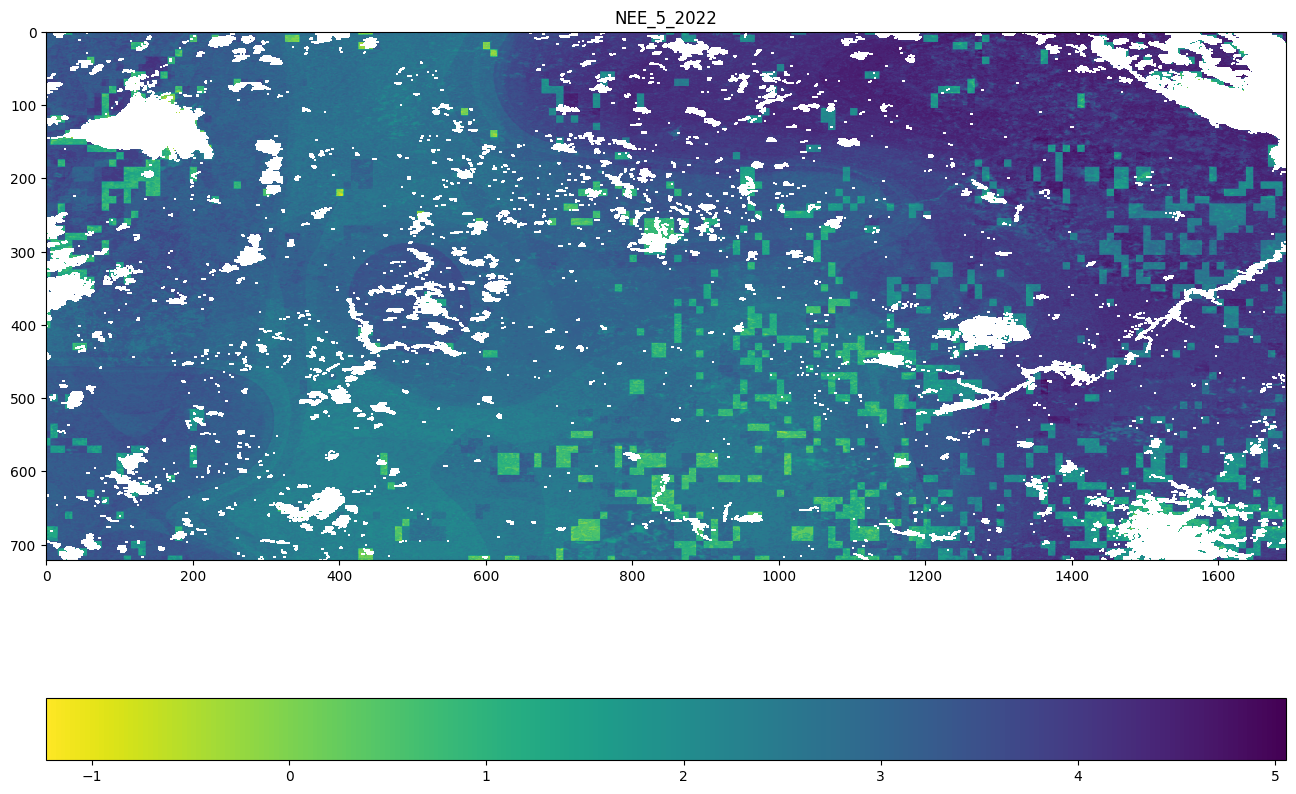

In [87]:
month = 5
with rio.open(f'/home/Unsertancy_Range_Between_{month}_{year}.tif', 'r') as src:
    data = src.read()

    plt.figure(figsize=(16, 12))
    img = plt.imshow(data[0], cmap='viridis_r')
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.title(f'NEE_{month}_{year}')
    plt.show()

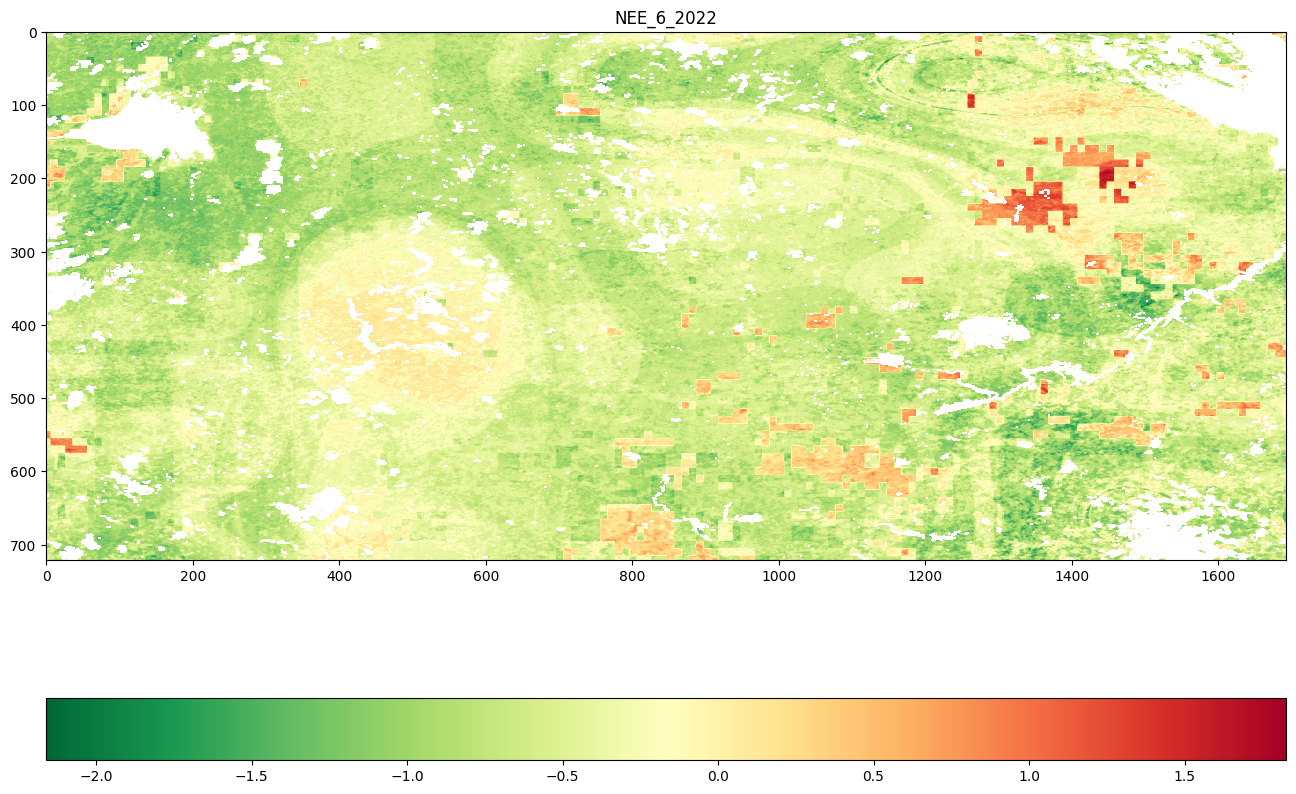

In [92]:
month = 6
with rio.open(f'/home/NEE_{month}_{year}.tif', 'r') as src:
    data = src.read()

    plt.figure(figsize=(16, 12))
    img = plt.imshow(data[0], cmap='RdYlGn_r')
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.title(f'NEE_{month}_{year}')
    plt.show()

In [95]:
!cp /home/Tver_Oblast_IGBP.tif ./

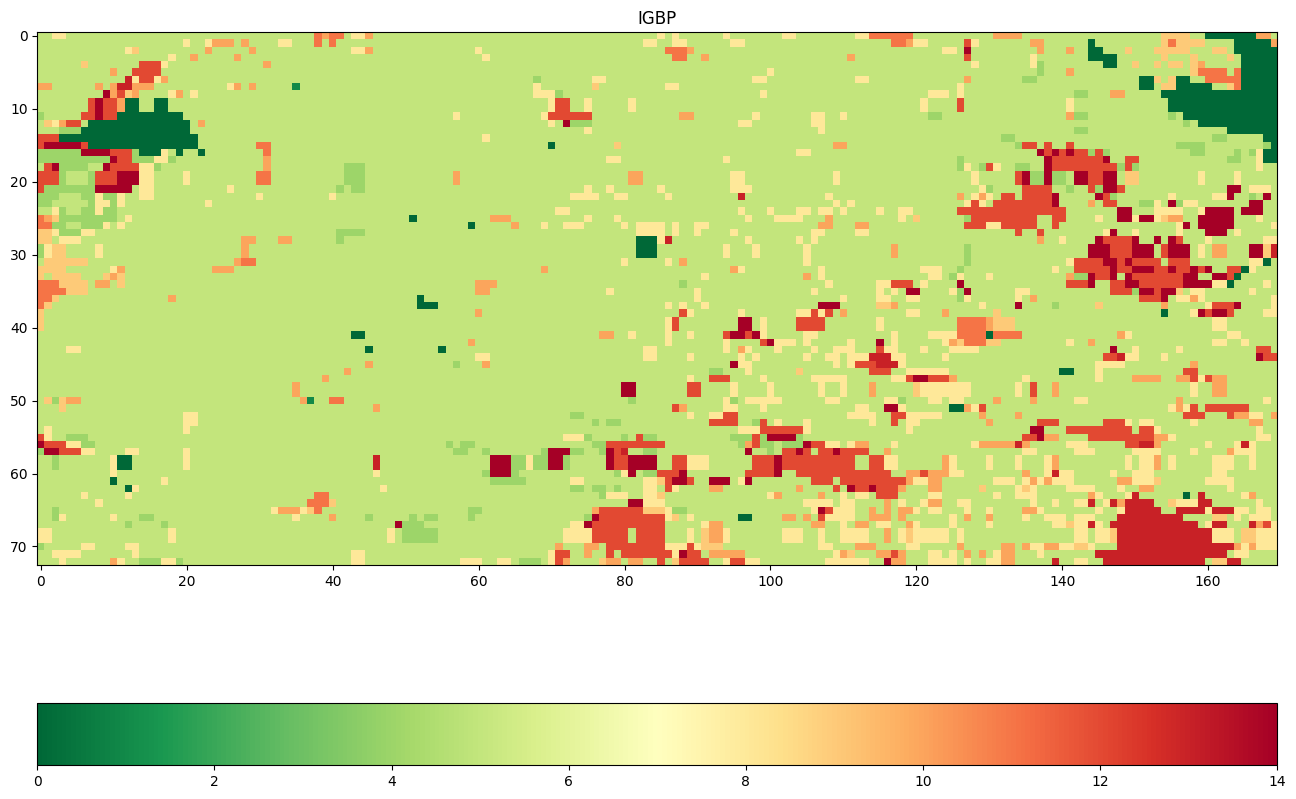

In [93]:
igbp_file_path = '/home/Tver_Oblast_IGBP.tif'

month = 6
with rio.open(igbp_file_path, 'r') as src:
    data = src.read()

    plt.figure(figsize=(16, 12))
    img = plt.imshow(data[0], cmap='RdYlGn_r')
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.title(f'IGBP')
    plt.show()

In [90]:
!cp /home/*2022*tif ../results/

In [97]:
gdf.to_file('./Tver.geojson', driver='GeoJSON')

In [99]:
data

array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [0.8801542,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)

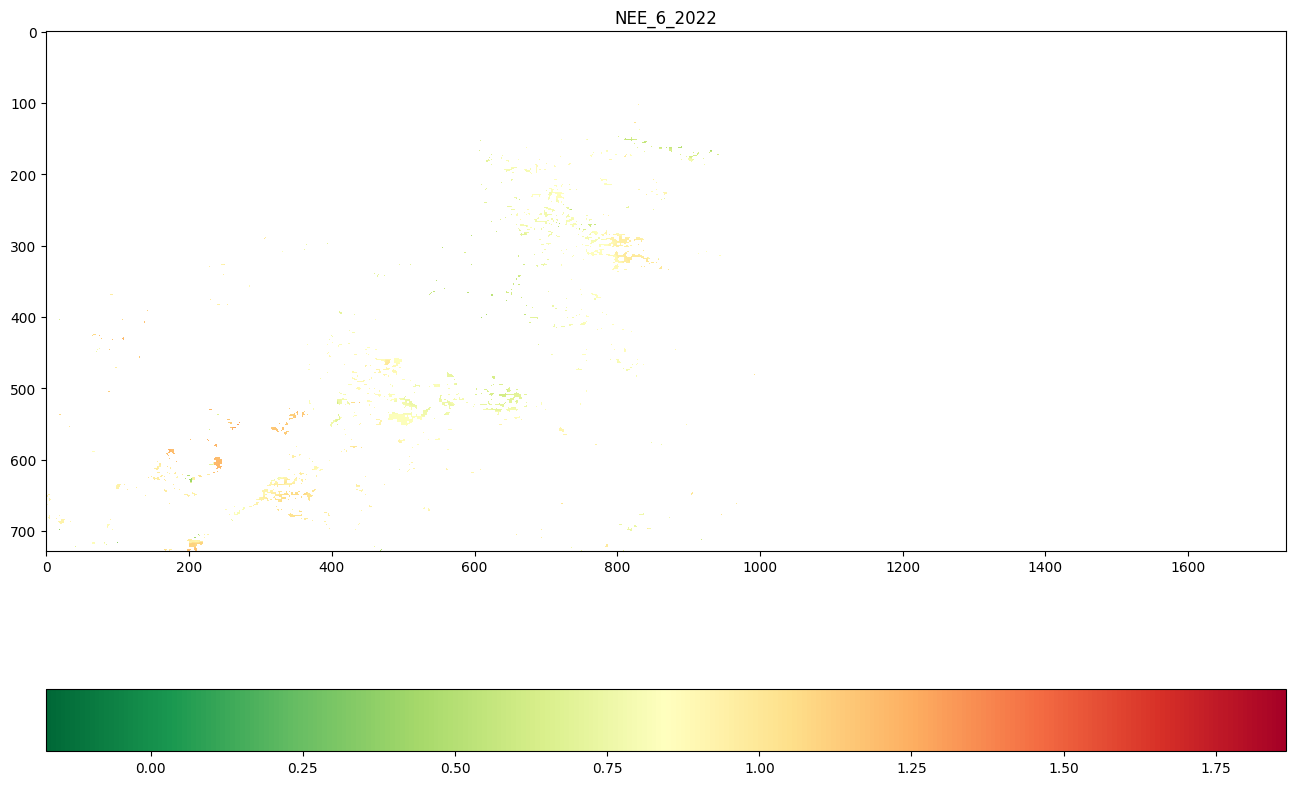

In [98]:
month = 6
with rio.open(f'./flux_2022-06.tiff', 'r') as src:
    data = src.read()

    plt.figure(figsize=(16, 12))
    img = plt.imshow(data[0], cmap='RdYlGn_r')
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.title(f'NEE_{month}_{year}')
    plt.show()